## Time Series Analysis

Time series is a series of data points indexed (or listed or graphed) in time order.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa. api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
ads = pd.read_csv("ads.csv")

In [3]:
ads

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630
...,...,...
211,2017-09-21T19:00:00,155890
212,2017-09-21T20:00:00,123395
213,2017-09-21T21:00:00,103080
214,2017-09-21T22:00:00,95155


In [4]:
currency = pd.read_csv("currency.csv")

In [5]:
currency

,Time,GEMS_GEMS_SPENT
0,05/01/2017,1199436
1,05/02/2017,1045515
2,05/03/2017,586111
3,05/04/2017,856601
4,05/05/2017,793775
...,...,...
295,2/20/18,2166449
296,2/21/18,1552313
297,2/22/18,2175548
298,2/23/18,2122606


In [6]:
ads = pd.read_csv("ads.csv", index_col=["Time"], parse_dates=["Time"])

currency = pd.read_csv("currency.csv", index_col=["Time"], parse_dates=["Time"])

In [7]:
currency

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775
...,...
2018-02-20,2166449
2018-02-21,1552313
2018-02-22,2175548


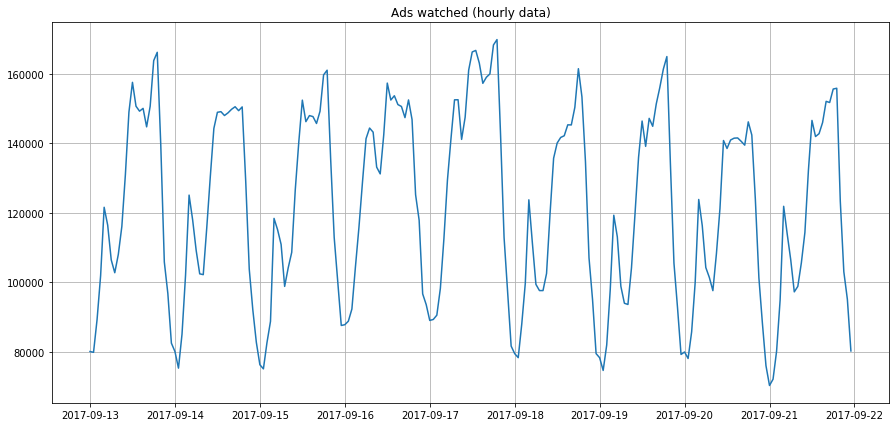

In [8]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title("Ads watched (hourly data)")
plt.grid(True)
plt.show()

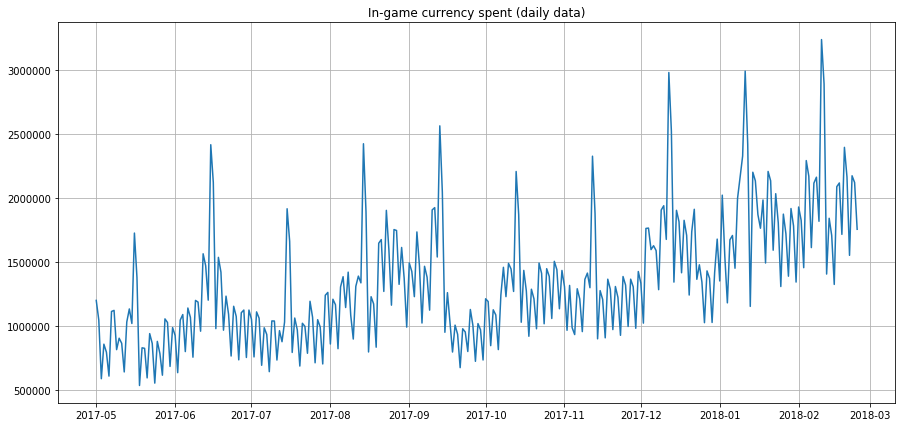

In [9]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title("In-game currency spent (daily data)")
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Naive hypothesis: 'tomorrow will be the same as today'

In [11]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

# prediction for the last observed day (past 24 hours)
moving_average(ads, 24) 

116805.0

To get the value for the next step, use the previous values to be actually observed.  Moving average also helps with smoothing the original time series to identify trends.

The wider the window, the smoother the trend.  In the case of very noisy data, this procedure can help detect common patterns.

In [12]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    """
    series - dataframe with timeseries
    window - rolling window size
    plot_intervals - show confidence intervals
    plot_anomalies - show anomalies
    """
    
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    # plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
            
    plt.plot(series[window:], label="Actual Values")
    plt.legend(loc="upper left")
    plt.grid(True)

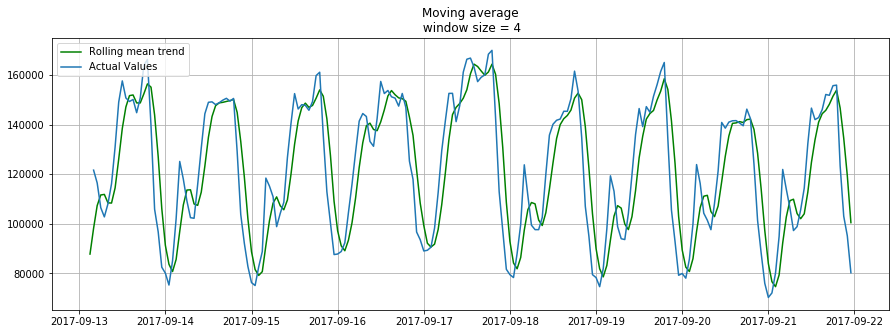

In [13]:
# smooth by the previous 4 hours
plot_moving_average(ads, 4)

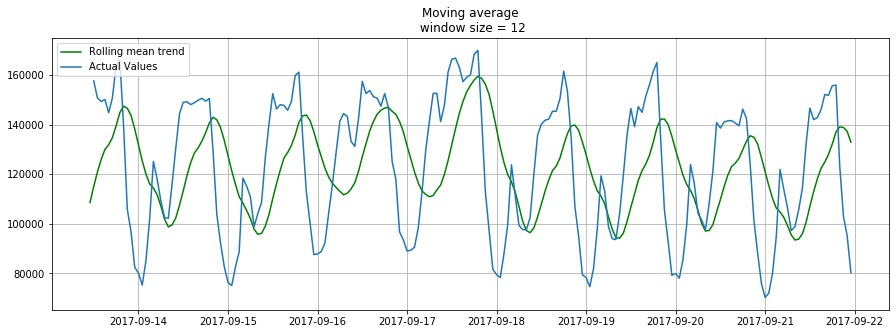

In [14]:
# smooth by the previous 12 hours
plot_moving_average(ads, 12)

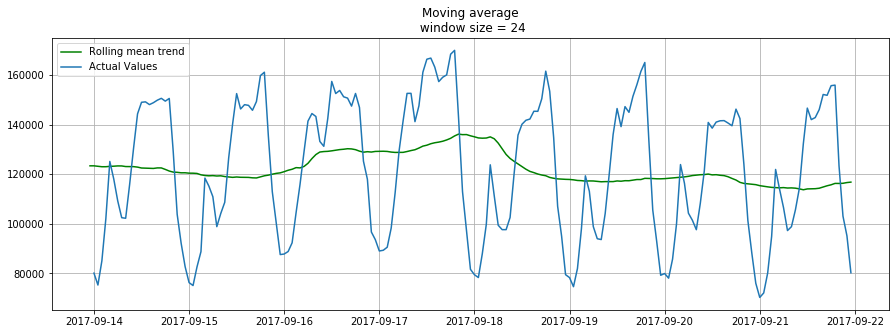

In [15]:
# smooth by the previous 24 hours
plot_moving_average(ads, 24)

During the weekend, the values are higher while fewer ads are watched on weekdays (less gaming on weekdays).

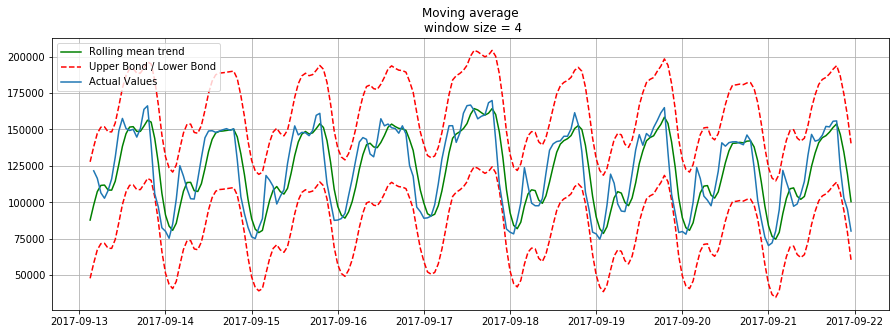

In [16]:
plot_moving_average(ads, 4, plot_intervals=True)

Example purposes only:

Create a simple anomaly detection system with the help of the moving average.  

In [17]:
ads_anomaly = ads.copy()

# creat 80% drop of ads
ads_anomaly.iloc[-10] = ads_anomaly.iloc[-10] * 0.2

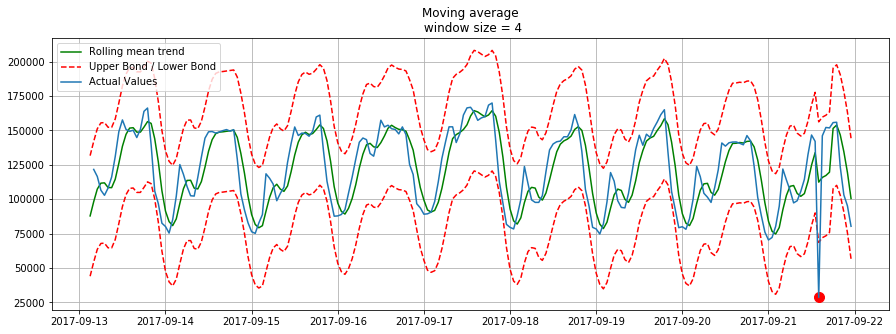

In [18]:
plot_moving_average(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

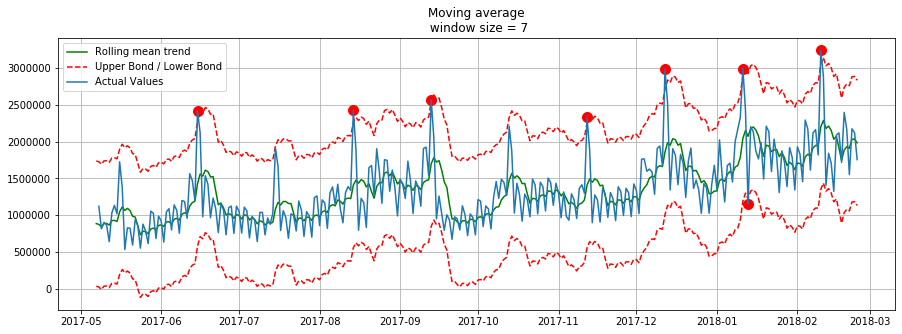

In [19]:
plot_moving_average(currency, 7, plot_intervals=True, plot_anomalies=True)

In [20]:
# alpha weight is a smoothing facter
# the smaller the alpha, the more influence the previous observation
# and the smoother the series is

def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [21]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context("seaborn-white"):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True)

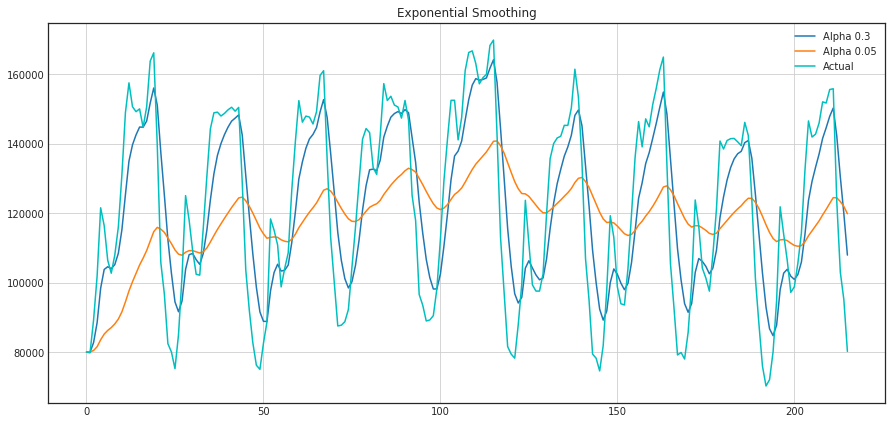

In [22]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

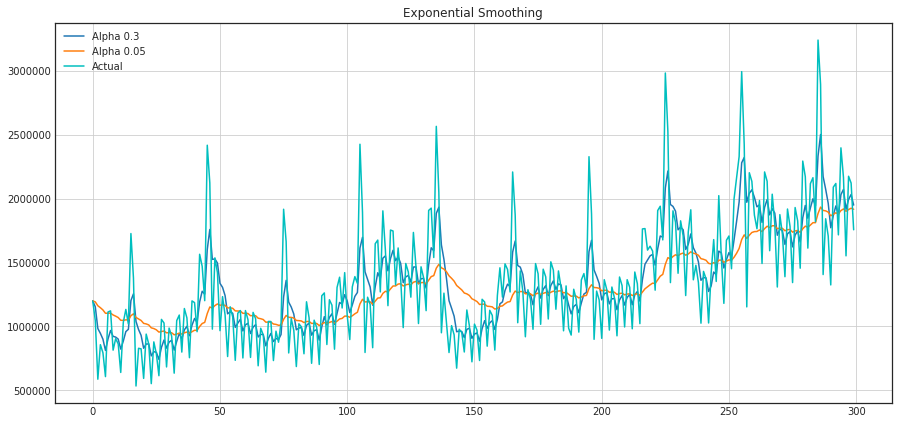

In [23]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

In [24]:
# predicting 2 future points
# level represents the intercept (current value of the series)
# beta represents slope (trend)
# assumption is that future direction of time series changes 
# depends on previous weighted changes

def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context("seaborn-white"):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

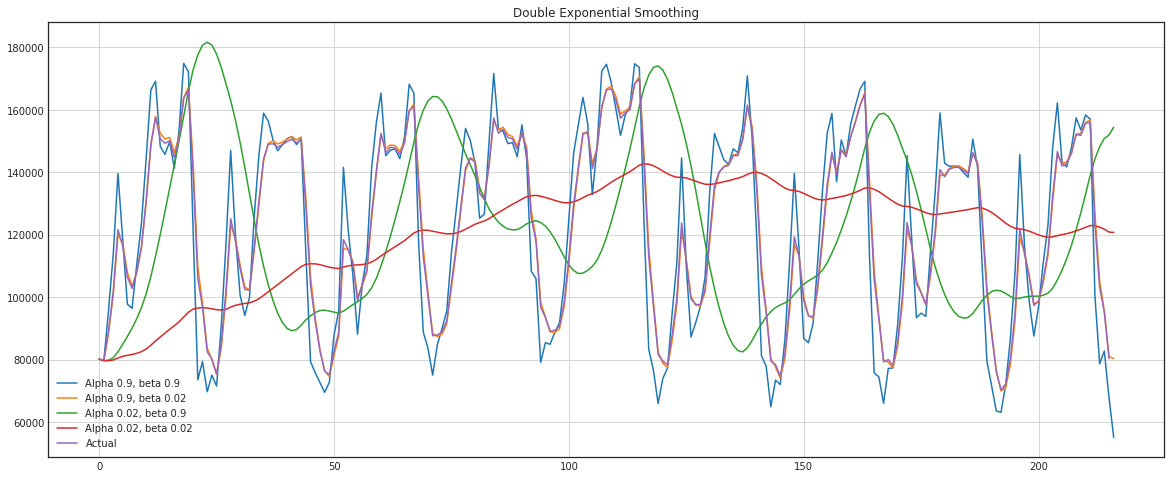

In [25]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

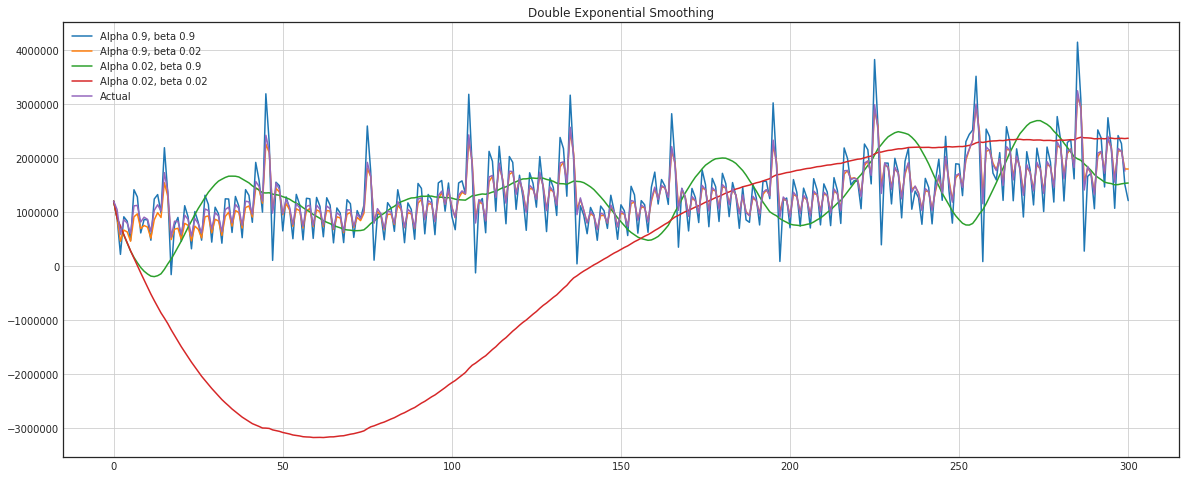

In [26]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

There are 2 tuning parameters:  α and  β

α is responsible for the series smoothing around the trend.

β is responsible for the smoothing of the trend itself. 

The larger the values, the more weight the most recent observations will have and the less smoothed the model series will be. 

In [27]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (normally values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting, increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [28]:
from sklearn.model_selection import TimeSeriesSplit 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [29]:
%%time

# there will be a constraint on how large smoothing parameters can be (0-1)
# to minimize loss function, use truncated Newton conjugate gradient

data = ads.Ads[:-20] # leave some data for testing

# initialize model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimize the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237
CPU times: user 2.31 s, sys: 18.8 ms, total: 2.32 s
Wall time: 2.33 s


In [30]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13)

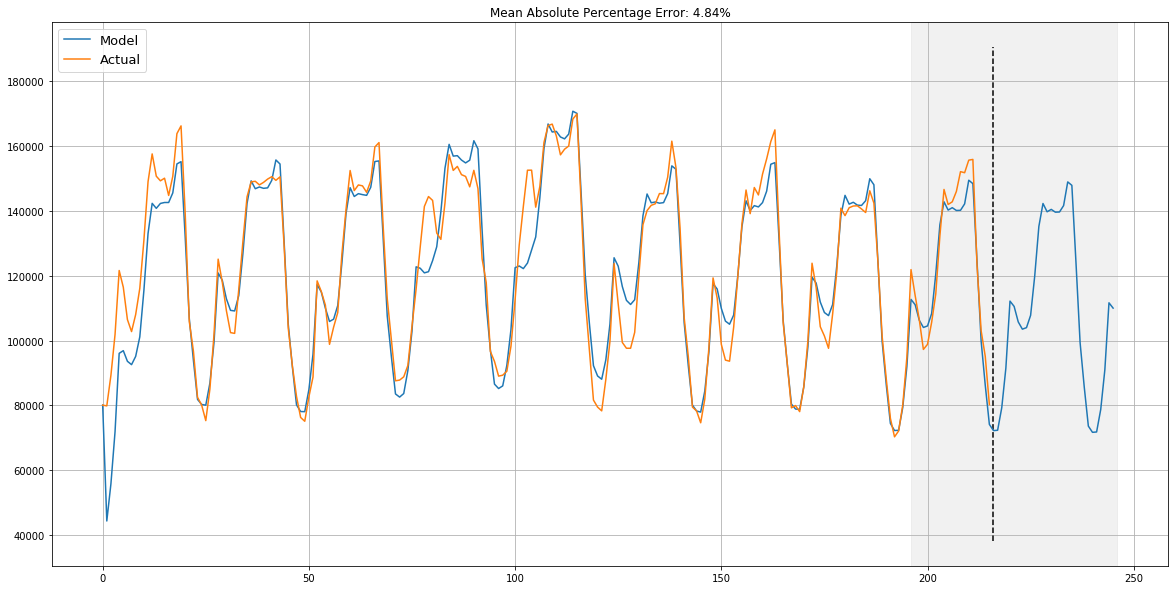

In [31]:
plotHoltWinters(ads.Ads)

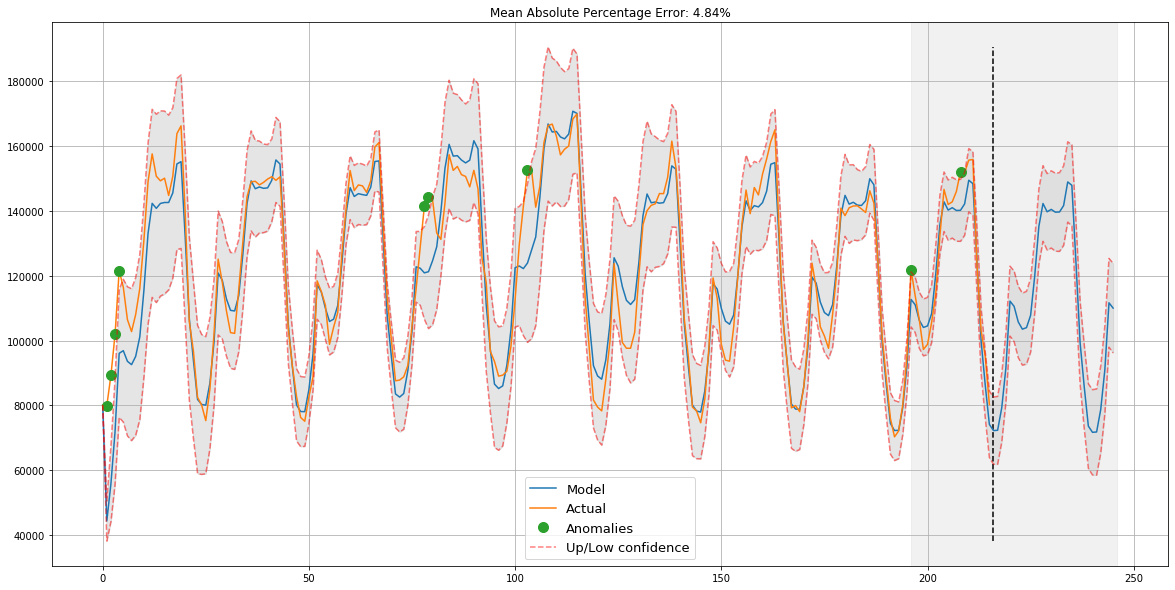

In [32]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

The model successfuly approximates the initial time series, capturing the daily seasonality, overall downwards trend, and even some anomalies. 

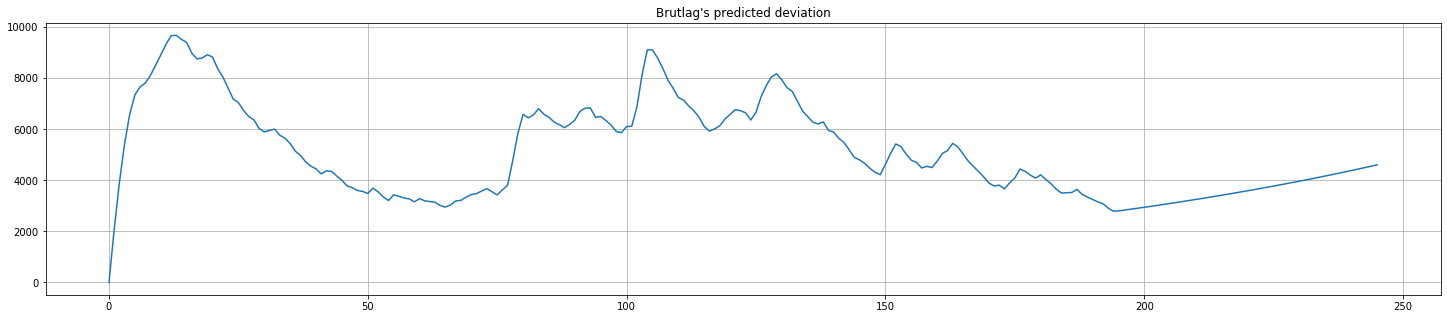

In [33]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis("tight")
plt.title("Brutlag's predicted deviation");

In [34]:
%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30 # 30-day seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777
CPU times: user 5.2 s, sys: 144 ms, total: 5.35 s
Wall time: 8.66 s


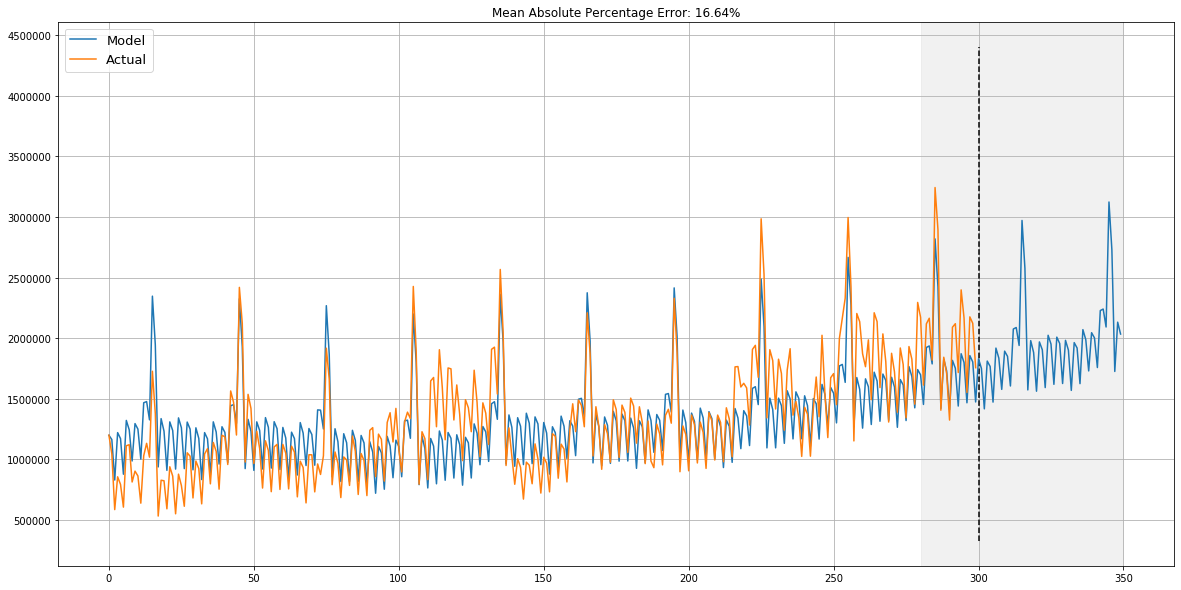

In [35]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

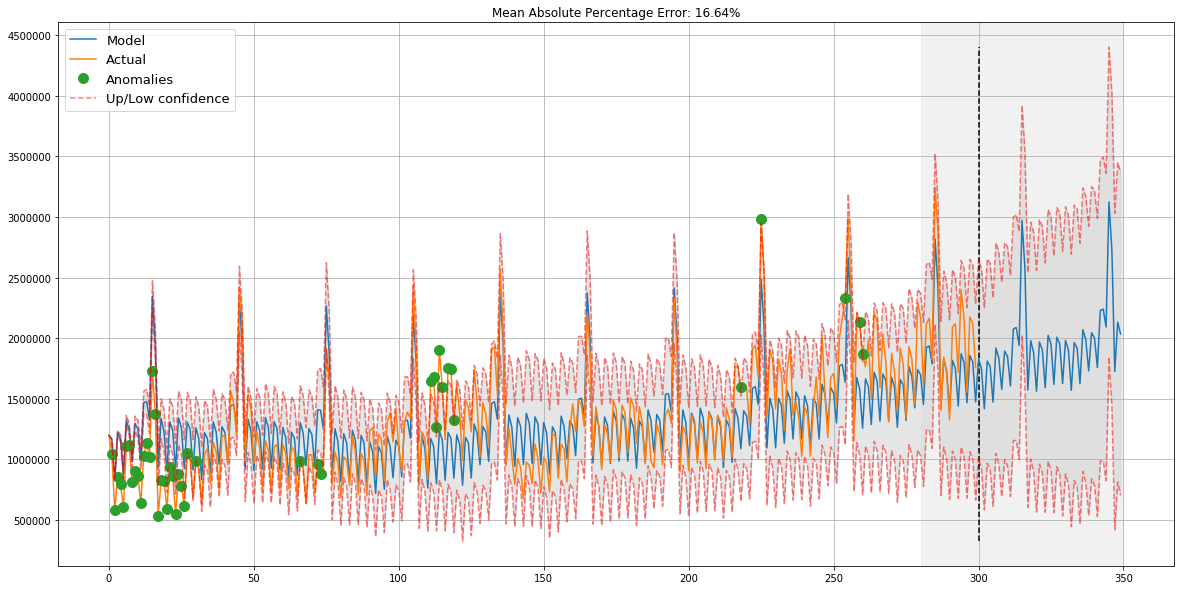

In [36]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

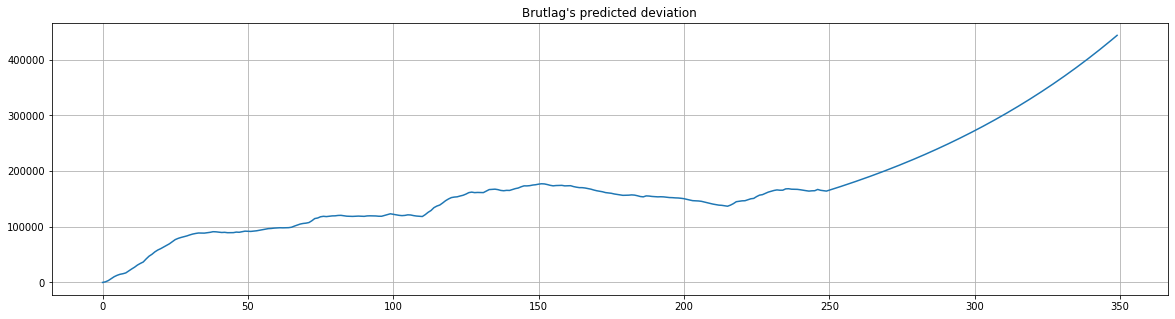

In [37]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis("tight")
plt.title("Brutlag's predicted deviation");

## Stationarity with SARIMA

The Dickey-Fuller test tests the null hypothesis that a unit root is present (non-stationarity) in an autoregressive model.  The alternative hypothesis is different depending on which version of the test is used: stationarity or trend-stationarity.

A p-value of less thatn 5% means the null hypothesis can be rejected; in the case of this dataset, this will mean there is stationarity.

In [38]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title("Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


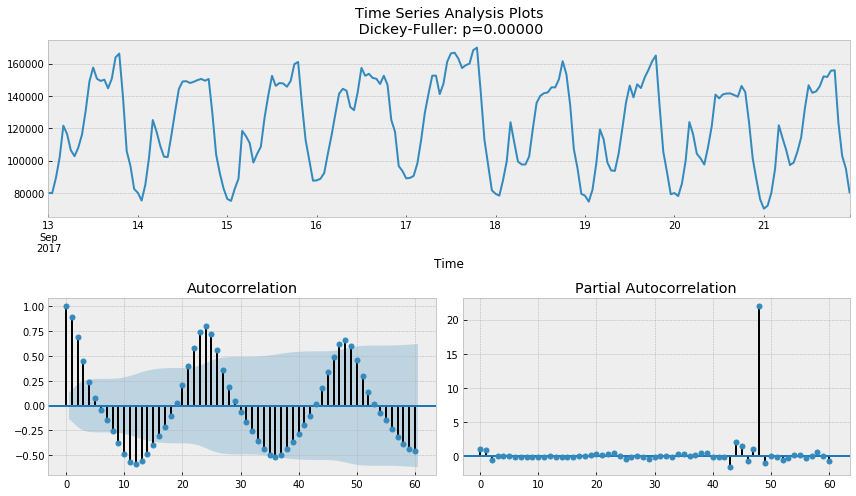

In [39]:
tsplot(ads.Ads, lags=60)

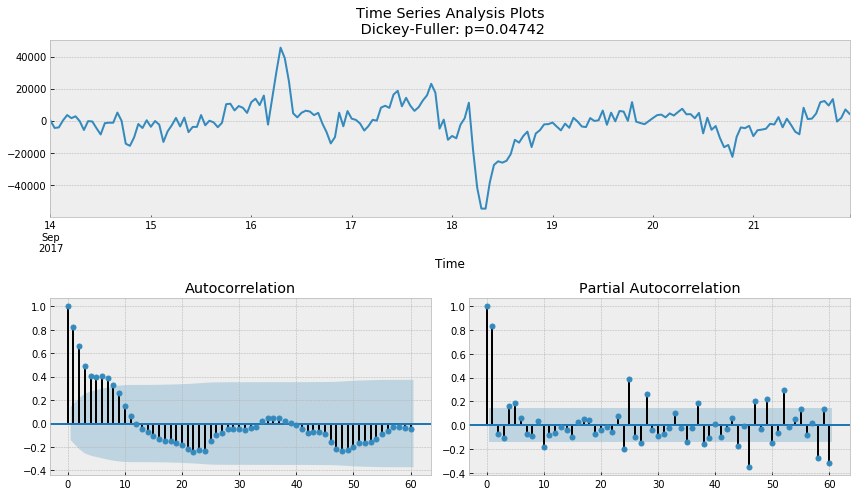

In [40]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

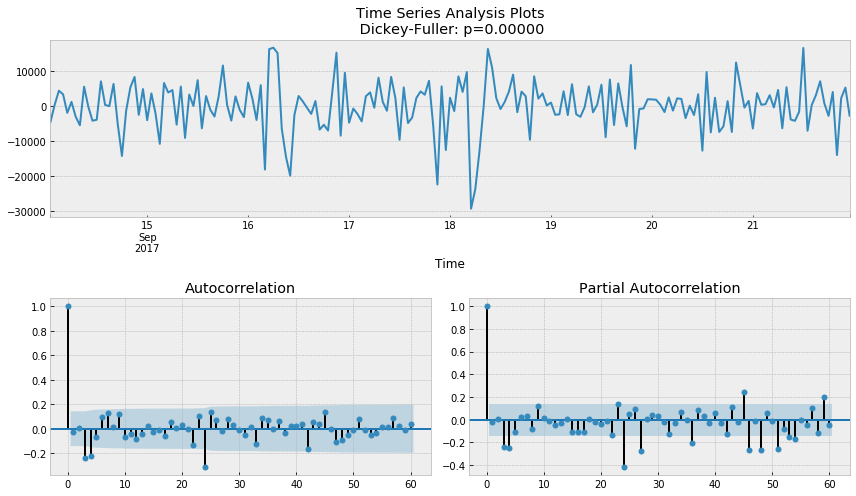

In [41]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

## SARIMA(p,d,q)(P,D,Q,s)

Seasonal Autoregression Moving Average model:

- AR(p): autoregression model, the assumption that the current series values depend on previous values with some lag.  p: Maximum lag in the model.  Use the PACF plot to find the biggest significant lag after which most other lags become insignificant.

- MA(q): moving average model, which models the error of the time series.  q: current error depends on the previous with some lag.

Autoregressive-moving-model:

AR(p) + MA(q) = ARMA(p,q)

If the series is stationary, it can be approximated with these 4 letters:

- I(d): order of integration, the number of nonseasonal differences needed to make the series stationary.  Using first differences, only 1 is needed.

ARIMA:

Ar(p) + I(d) + MA(q) = ARIMA(p,d,q)

- S(s): seasonality, the season period length of the series

Three parameters:

- P: order of autoregression for seasonal component of the model (from PACF).  Look for number of significant lags, multiples of season period length.  

- Q: moving average model, using ACF plot instead.

- D: order of seasonal integration, 1 or 0, depending on whether seasonal difference were applied or not.

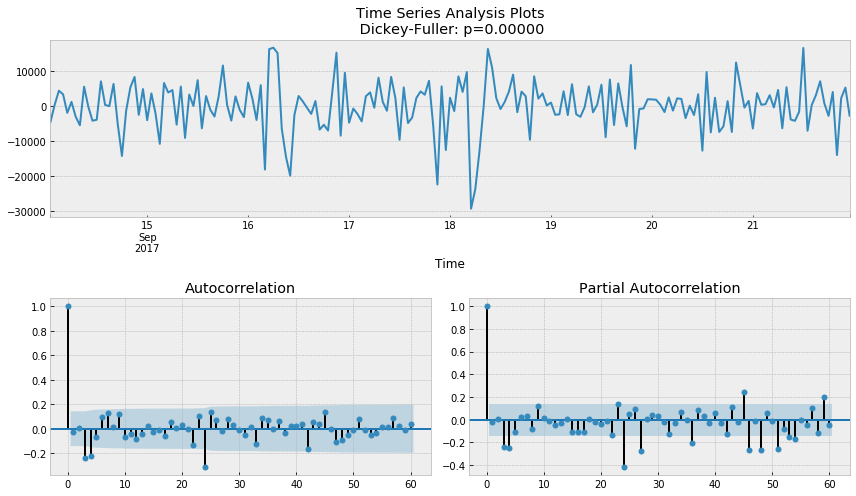

In [42]:
tsplot(ads_diff[24+1:], lags=60)

In [43]:
# set initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# create list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [44]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # use try-except because as some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ["parameters", "aic"]
    # sort in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by="aic", ascending=True).reset_index(drop=True)
    
    return result_table

In [45]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information w

/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/adamdickson/opt/anaconda3/lib/python3.7/si

/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



CPU times: user 5min 47s, sys: 5.25 s, total: 5min 52s
Wall time: 4min


In [46]:
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


In [47]:
# set parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Tue, 17 Nov 2020   AIC                           3888.642
Time:                                      16:18:03   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

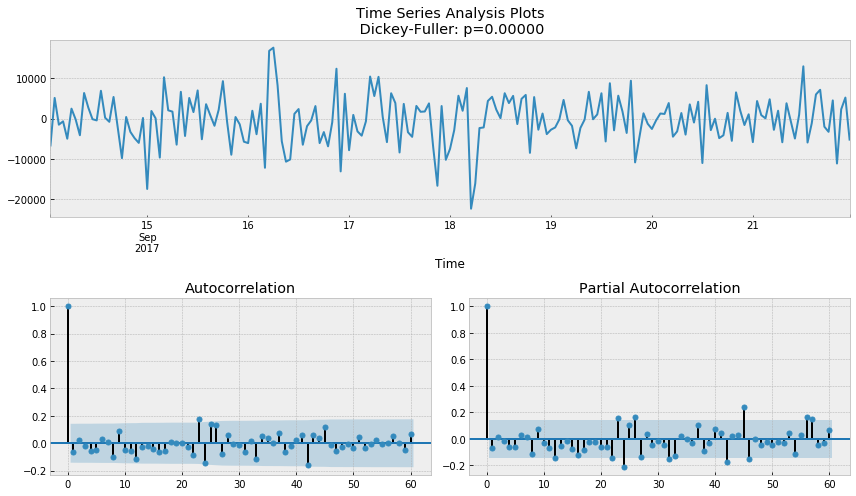

In [48]:
# inspect the residuals
tsplot(best_model.resid[24+1:], lags=60)

In [49]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # add model values
    data = series.copy()
    data.columns = ["actual"]
    data["arima_model"] = model.fittedvalues
    # shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data["arima_model"][:s+d] = np.NaN
    
    # forecast on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data["actual"][s+d:], data["arima_model"][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

/Users/adamdickson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


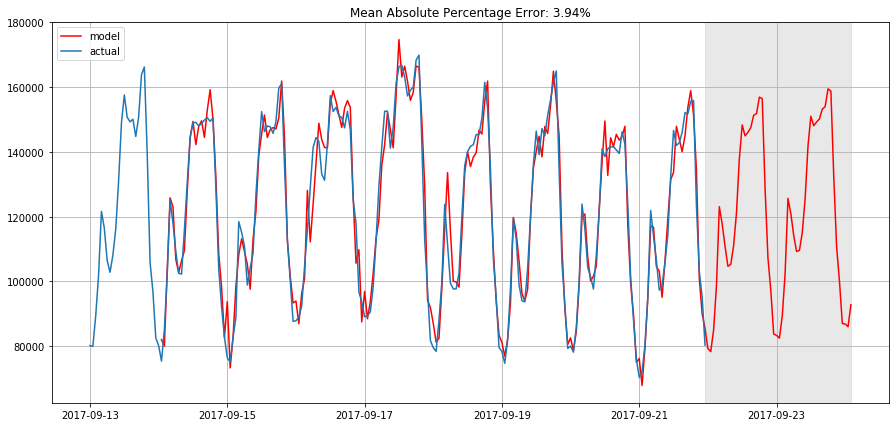

In [50]:
plotSARIMA(ads, best_model, 50)